<a href="https://colab.research.google.com/github/aleksandrast12/PUM_projekt_PZS/blob/Ola/Projekt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [126]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
import sklearn

In [110]:

# y to quality

df = pd.read_csv("test.csv")

#df.drop_duplicates() - nie obowiazuje gdyz nawet przy jednym powtarzajacym sie elemencie inne cechy rozniace sie moga miec wplyw na ocene jakosci

#nie musimy usuwac kolumn
columns = ['fixed acidity',"volatile acidity","citric acid","residual sugar","chlorides","free sulfur dioxide","total sulfur dioxide","density","pH","sulphates","alcohol","quality"]
columnsnotQuality = ['fixed acidity',"volatile acidity","citric acid","residual sugar","chlorides","free sulfur dioxide","total sulfur dioxide","density","pH","sulphates","alcohol"]
FeaturesToConvert = ['citric acid','residual sugar','chlorides']
FeaturesToConvert = ['citric acid','residual sugar','chlorides']
for feature in FeaturesToConvert:
   df[feature] = df[feature].str.strip('-_')
for feature in FeaturesToConvert:
  df[feature] = df[feature].astype('float64')
for column in columns:
   df[column] = df[column].replace({'':np.nan})
#df.isna().sum()
df['density'] = df['density'].fillna(method='pad')

for column in  df[columnsnotQuality]:
  df[column]=np.abs(df[column])
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3- Q1
  df = df.drop(df.loc[df[column] > (Q3 + 1.5 * IQR)].index)
  df = df.drop(df.loc[df[column] < (Q1- 1.5 * IQR)].index)
dfnoQuality = df.drop(columns=['quality'])
scaler = preprocessing.StandardScaler().fit(dfnoQuality)
numerical_columns = dfnoQuality.select_dtypes(include=[float, int]).columns
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# features = df.drop(columns=['quality'])
# plt.figure(figsize=(10, 8))
# sns.heatmap(features.corr(), annot = True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
# plt.title('Korelacja cech numerycznych')
# plt.show()

#df.info()
#df.head()

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0      -0.517383          1.080055    -1.364671       -0.639225  -0.167169   
1      -0.240257          2.173545    -1.364671        0.955325   1.434599   
2      -0.240257          1.444552    -1.142773        0.271947   0.997753   
3       2.115311         -1.471421     1.741897       -0.639225  -0.239977   
4      -0.517383          1.080055    -1.364671       -0.639225  -0.167169   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0            -0.441353             -0.282198  0.790696  1.419610  -0.610668   
1             1.189601              1.058458  0.148392 -0.962884   0.460596   
2             0.024634              0.530321  0.276853 -0.501756   0.192780   
3             0.257627              0.774077  0.919157 -1.270302  -0.432124   
4            -0.441353             -0.282198  0.790696  1.419610  -0.610668   

    alcohol  quality  
0 -1.000189        5  
1 -0.58054

Pozostałe cechy: Index(['fixed acidity', 'volatile acidity', 'citric acid', 'chlorides',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'quality'],
      dtype='object')


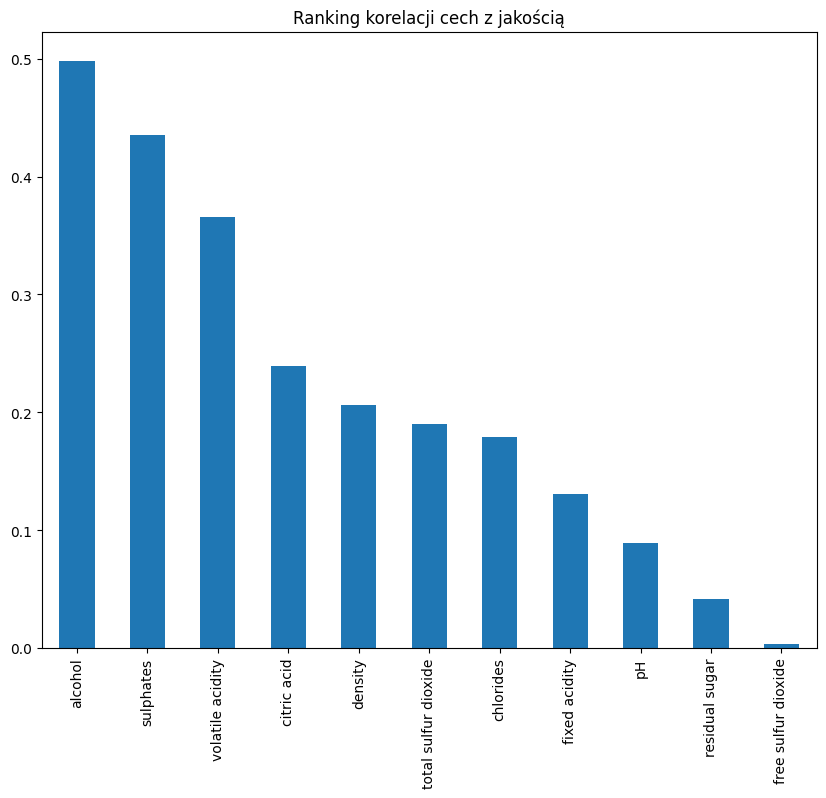

In [111]:
corr_quality = df.corr()['quality'].drop('quality').abs()
corr_quality_sort = corr_quality.sort_values(ascending=False)
corr_quality_sort.plot.bar(figsize=(10, 8))
plt.title('Ranking korelacji cech z jakością')
features_drop = corr_quality_sort.nsmallest(2).index
df_reduced = df.drop(columns=features_drop)

# wyświetlenie pozostałych cech
print("Pozostałe cechy:", df_reduced.columns)
plt.show()



wariancja [0.31309624 0.23841884 0.11592035 0.09467399 0.08080354 0.07049266
 0.05492427]


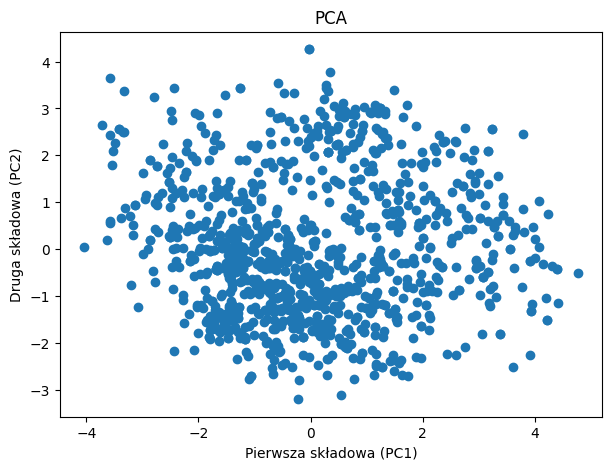

In [108]:

features = df_reduced.drop(columns=['quality'])
pca = PCA(n_components=0.95)  # zachowanie 95% wariancji
X_pca = pca.fit_transform(features)

plt.figure(figsize=(7, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.xlabel('Pierwsza składowa (PC1)')
plt.ylabel('Druga składowa (PC2)')
plt.title('PCA')
print("wariancja", pca.explained_variance_ratio_)
plt.show()

In [107]:
X_df = df_reduced[['fixed acidity','volatile acidity','citric acid', 'chlorides', 'total sulfur dioxide', 'density','pH', 'sulphates', 'alcohol']]
Y_df = df_reduced['quality']
X_train, X_test, Y_train, Y_test = train_test_split(X_df, Y_df, random_state=50)

# X_train = train_df[['fixed acidity','volatile acidity','citric acid', 'chlorides', 'total sulfur dioxide', 'density','pH', 'sulphates', 'alcohol']]
# Y_train = train_df['quality']
# X_test = test_df[['fixed acidity','volatile acidity','citric acid', 'chlorides', 'total sulfur dioxide', 'density','pH', 'sulphates', 'alcohol']]
# Y_test = test_df['quality']

# **Model Podstawowy**

In [60]:
df_reduced.head()

,fixed acidity,volatile acidity,citric acid,chlorides,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.517383,1.080055,-1.364671,-0.167169,-0.282198,0.790696,1.419610,-0.610668,-1.000189,5
1,-0.240257,2.173545,-1.364671,1.434599,1.058458,0.148392,-0.962884,0.460596,-0.580549,5
2,-0.240257,1.444552,-1.142773,0.997753,0.530321,0.276853,-0.501756,0.192780,-0.580549,5
3,2.115311,-1.471421,1.741897,-0.239977,0.774077,0.919157,-1.270302,-0.432124,-0.580549,6
4,-0.517383,1.080055,-1.364671,-0.167169,-0.282198,0.790696,1.419610,-0.610668,-1.000189,5


In [105]:

linReg = LinearRegression().fit(X_train, Y_train)
linReg.score(X_train,Y_train)
linReg.coef_
linReg.intercept_
y_predic = np.round(linReg.predict(X_test))
print(y_predic)

[5. 5. 6. 6. 6. 6. 7. 6. 6. 6. 5. 6. 5. 6. 6. 5. 6. 6. 5. 6. 5. 6. 5. 6.
 6. 6. 5. 6. 6. 6. 6. 6. 6. 5. 5. 5. 6. 5. 6. 5. 5. 5. 5. 5. 5. 5. 6. 5.
 6. 6. 5. 6. 5. 6. 5. 6. 5. 5. 6. 5. 5. 6. 6. 6. 6. 6. 6. 5. 5. 6. 6. 6.
 5. 5. 5. 6. 5. 5. 6. 5. 6. 5. 5. 5. 6. 6. 5. 6. 6. 6. 5. 5. 6. 6. 5. 6.
 5. 6. 6. 6. 6. 6. 6. 6. 5. 6. 5. 5. 5. 6. 5. 5. 5. 6. 5. 5. 5. 6. 5. 5.
 5. 6. 5. 6. 5. 6. 5. 6. 5. 5. 6. 6. 6. 6. 6. 6. 6. 6. 6. 5. 6. 6. 5. 6.
 6. 7. 5. 6. 6. 5. 5. 5. 6. 7. 6. 6. 6. 5. 6. 6. 6. 5. 6. 5. 5. 5. 6. 6.
 6. 6. 5. 6. 5. 6. 5. 5. 5. 6. 6. 7. 6. 5. 6. 7. 5. 5. 6. 6. 6. 6. 6. 5.
 6. 5. 6. 6. 5. 5. 6. 6. 5. 5. 7. 6. 6. 5. 5. 6. 5. 6. 6. 5. 5. 6. 5. 5.
 5. 6. 6. 6. 5. 5. 6. 5. 5. 5. 7. 6. 6. 7. 5. 6. 5. 5. 6. 5. 6. 6. 6. 6.
 6. 6. 5. 5. 5. 6. 5. 6. 5. 6. 6. 6. 6. 6. 7. 6. 6. 5. 6. 6. 6. 6. 6. 5.
 5. 6. 5. 5. 6. 6. 6. 6. 5. 5. 6. 5. 6. 5. 6. 5. 5. 6. 5. 5.]


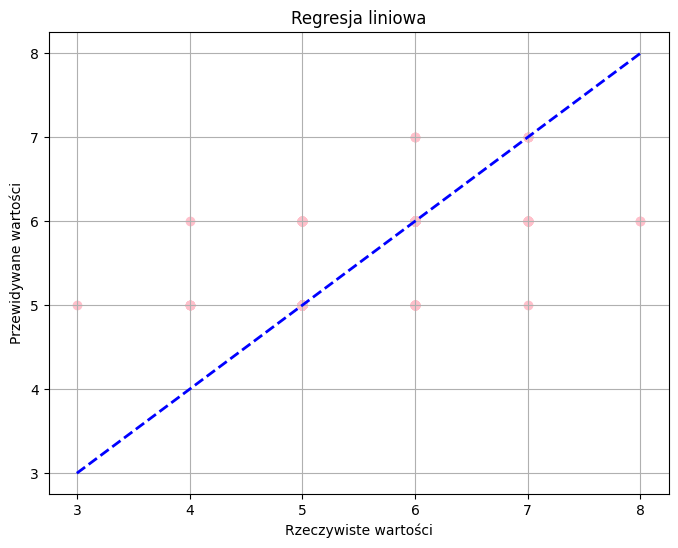

In [101]:
plt.figure(figsize=(8, 6))
plt.scatter(Y_test, y_predic, color='pink')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], color='blue', linestyle='--', linewidth=2)
plt.xlabel('Rzeczywiste wartości')
plt.ylabel('Przewidywane wartości')
plt.title('Regresja liniowa')
plt.grid(True)
plt.show()

In [102]:
y_true = Y_test
print ("regresja liniowa sredni błąd bezwględny;",  mean_absolute_error(y_true,y_predic))


regresja liniowa sredni błąd bezwględny; 0.4119718309859155


In [103]:
y_true = Y_test
print("regresja liniowa mediana róznic miedzy wartosciami prognozowanymi a rzeczywistymi",median_absolute_error(y_true,y_predic))

regresja liniowa mediana róznic miedzy wartosciami prognozowanymi a rzeczywistymi 0.0


In [104]:
y_true = Y_test
print("regresja liniowa r2", r2_score(y_true,y_predic))

regresja liniowa r2 0.259688013136289


Dzięki r2 mozemy zobaczyć iż regresja liniowa nie jest najlepszym wyborem w tym przypadku gdyż dopasowanie wynosi tylko około 39%

#**Cross Validation regresja liniowa**


In [133]:
rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=45)
lin = LinearRegression()
cv_scores_lin = cross_val_score(lin, X_df , Y_df, cv=rkf, scoring='r2')
print(cv_scores_lin)

[0.35229238 0.31659194 0.45968443 0.36452035 0.34256069 0.32528665
 0.41354241 0.31348433 0.37660442 0.44082828 0.39320685 0.39237009
 0.35881036 0.39350652 0.31027554]


#**Huber Regressor**

In [134]:
huber = HuberRegressor().fit(X_train,Y_train)
huber.score(X_train,Y_train)
huber.coef_
huber.intercept_
y_predic_huber = np.round(huber.predict(X_test))
print (y_predic_huber)

[5. 5. 6. 6. 6. 6. 7. 6. 6. 6. 5. 6. 6. 6. 6. 5. 5. 6. 5. 6. 5. 6. 5. 6.
 6. 6. 5. 6. 6. 6. 6. 6. 5. 5. 5. 5. 6. 5. 6. 6. 5. 5. 5. 5. 5. 5. 6. 5.
 6. 5. 5. 7. 5. 6. 5. 6. 5. 5. 6. 5. 5. 6. 6. 6. 6. 6. 6. 5. 6. 6. 6. 6.
 5. 5. 5. 6. 5. 5. 6. 5. 5. 5. 5. 5. 6. 6. 5. 6. 6. 6. 5. 5. 6. 6. 5. 6.
 5. 6. 6. 6. 7. 6. 6. 6. 5. 6. 5. 5. 5. 6. 5. 5. 5. 6. 5. 5. 5. 6. 5. 5.
 5. 6. 5. 6. 5. 6. 5. 6. 5. 5. 6. 6. 6. 6. 6. 6. 6. 6. 6. 5. 6. 6. 5. 6.
 6. 7. 5. 6. 6. 5. 5. 5. 6. 7. 6. 6. 6. 5. 6. 6. 6. 5. 6. 5. 5. 5. 6. 6.
 6. 6. 5. 6. 5. 6. 5. 5. 5. 6. 6. 7. 6. 5. 6. 7. 5. 5. 6. 6. 6. 6. 6. 5.
 6. 5. 6. 6. 5. 5. 6. 6. 5. 5. 7. 6. 6. 5. 5. 6. 5. 6. 6. 5. 5. 6. 5. 5.
 5. 6. 6. 6. 5. 5. 6. 5. 5. 5. 7. 6. 7. 7. 5. 6. 5. 5. 6. 5. 6. 6. 6. 6.
 6. 6. 5. 5. 5. 6. 5. 6. 5. 6. 6. 6. 6. 6. 7. 6. 6. 5. 6. 6. 6. 6. 7. 5.
 5. 6. 5. 5. 6. 6. 6. 5. 5. 5. 6. 5. 7. 5. 5. 5. 5. 6. 5. 5.]


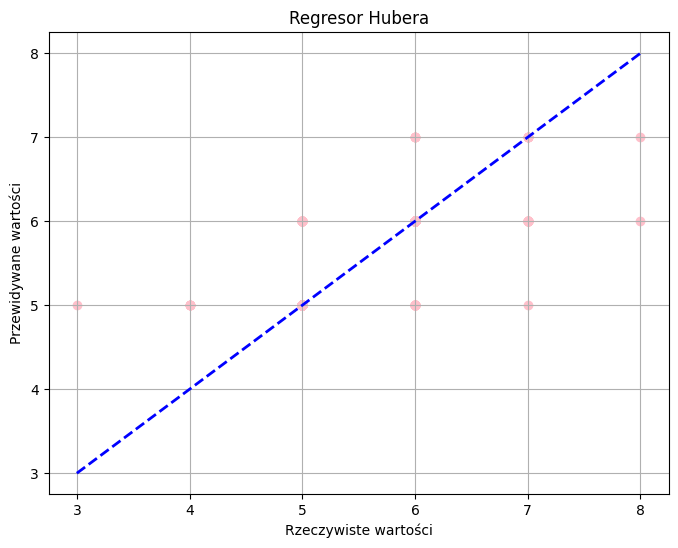

In [135]:
plt.figure(figsize=(8, 6))
plt.scatter(Y_test, y_predic_huber, color='pink')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], color='blue', linestyle='--', linewidth=2)
plt.xlabel('Rzeczywiste wartości')
plt.ylabel('Przewidywane wartości')
plt.title('Regresor Hubera')
plt.grid(True)
plt.show()

In [136]:
print("regresja Hubera",mean_absolute_error(y_true,y_predic_huber))

regresja Hubera 0.40492957746478875


In [137]:
print("regresja Hubera",median_absolute_error(y_true,y_predic_huber))

regresja Hubera 0.0


In [138]:
print("regresja Hubera r2",r2_score(y_true,y_predic_huber))

regresja Hubera r2 0.29466338259441704


Dzięki r2 mozemy zobaczyć iż regresor Hubera nie jest najlepszym wyborem w tym przypadku gdyż dopasowanie wynosi około 38% czyli mniej niż regresja liniowa

#**Cross Validation Huber Regressor**

In [139]:
rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=45)
hub = HuberRegressor()
cv_scores_hub = cross_val_score(hub, X_df , Y_df, cv=rkf, scoring='r2')
print(cv_scores_lin)

[0.35229238 0.31659194 0.45968443 0.36452035 0.34256069 0.32528665
 0.41354241 0.31348433 0.37660442 0.44082828 0.39320685 0.39237009
 0.35881036 0.39350652 0.31027554]


#**Regresja wielomianowa 2 i 3 stopnia**

#2 stopień

In [79]:

model = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('linear', LinearRegression())
])

model.fit(X_train, Y_train)
y_predic_poly2 = np.round(model.predict(X_test))
print(y_predic_poly2)


[5. 5. 5. 6. 6. 6. 7. 6. 6. 6. 5. 7. 5. 5. 5. 5. 5. 6. 5. 6. 5. 6. 5. 6.
 6. 5. 6. 6. 6. 6. 6. 7. 6. 5. 5. 5. 5. 5. 6. 6. 5. 5. 5. 5. 5. 5. 6. 5.
 6. 5. 5. 7. 5. 6. 5. 5. 5. 5. 6. 5. 5. 7. 6. 7. 6. 6. 6. 5. 5. 6. 5. 6.
 5. 5. 5. 6. 5. 5. 6. 5. 5. 5. 5. 5. 6. 5. 5. 6. 6. 6. 5. 4. 5. 6. 5. 6.
 5. 6. 6. 6. 7. 6. 6. 6. 5. 5. 5. 5. 5. 6. 5. 5. 5. 6. 5. 5. 5. 6. 5. 5.
 5. 6. 5. 6. 5. 6. 5. 6. 5. 5. 6. 6. 6. 5. 6. 6. 6. 6. 6. 5. 6. 6. 5. 6.
 7. 7. 5. 6. 5. 5. 5. 5. 6. 7. 6. 6. 6. 5. 6. 6. 6. 5. 6. 5. 5. 6. 6. 6.
 6. 6. 5. 6. 5. 6. 5. 5. 5. 6. 6. 7. 6. 5. 6. 7. 5. 5. 6. 6. 5. 5. 6. 5.
 6. 5. 6. 6. 5. 5. 6. 6. 5. 5. 7. 6. 6. 5. 5. 5. 5. 5. 6. 5. 5. 6. 5. 5.
 5. 6. 6. 6. 5. 5. 6. 5. 5. 5. 7. 6. 7. 7. 5. 5. 5. 5. 6. 5. 7. 6. 6. 6.
 6. 6. 5. 5. 5. 5. 5. 6. 5. 6. 6. 6. 6. 6. 7. 6. 7. 5. 6. 6. 6. 6. 7. 5.
 5. 6. 5. 5. 5. 6. 6. 6. 5. 5. 6. 5. 7. 5. 6. 6. 6. 6. 5. 5.]


In [80]:

print("regresja wielomianowa 2 stopnia r2: ", model.score(X_test, Y_test))

regresja wielomianowa 2 stopnia r2:  0.35846110417687904


Dzięki r2 mozemy zobaczyć iż regresja wielomianowa 2 stopnia nie jest najlepszym wyborem w tym przypadku gdyż dopasowanie wynosi tylko około 36% czyli mniej niz liniowa i Hubera

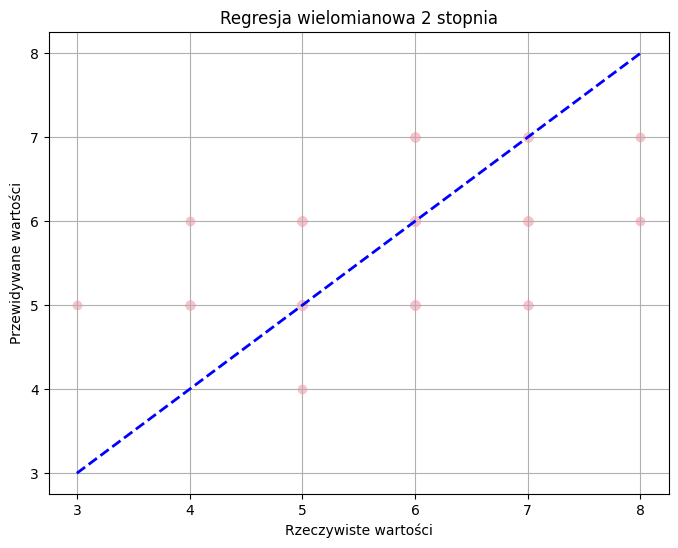

In [81]:
plt.figure(figsize=(8, 6))
plt.scatter(Y_test, y_predic_poly2, color='pink')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], color='blue', linestyle='--', linewidth=2)
plt.xlabel('Rzeczywiste wartości')
plt.ylabel('Przewidywane wartości')
plt.title('Regresja wielomianowa 2 stopnia')
plt.grid(True)
plt.show()

#**Cross validation wielomianowa 2 stopnia**


In [131]:
rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
lin = LinearRegression()
xpol2 = PolynomialFeatures(2)
X2 = xpol2.fit_transform(X_df)
cv_scores_poly2 = cross_val_score(lin, X2, Y_df, cv=rkf,scoring='r2')
print(cv_scores_poly2)

[0.3939213  0.37392942 0.35033093 0.36398902 0.35416028 0.38283518
 0.25039828 0.38447366 0.45775373 0.38135627 0.44984161 0.37096718
 0.36498049 0.26819519 0.35796944]


# 3 stopień

In [92]:
model3 = Pipeline([
    ('poly', PolynomialFeatures(degree=3)),
    ('linear', LinearRegression())
])

model3.fit(X_train, Y_train)
y_predic_poly3 = np.round(model3.predict(X_test),decimals  =0)
print(y_predic_poly3)

[5. 4. 5. 6. 5. 6. 7. 6. 6. 5. 5. 7. 5. 6. 5. 4. 5. 6. 5. 6. 5. 5. 7. 5.
 6. 5. 5. 6. 6. 6. 5. 6. 5. 5. 5. 5. 6. 5. 7. 6. 6. 5. 6. 6. 4. 6. 6. 6.
 6. 6. 5. 7. 6. 6. 5. 5. 5. 5. 6. 6. 5. 7. 6. 7. 6. 6. 6. 5. 4. 6. 6. 6.
 5. 5. 6. 6. 5. 5. 7. 5. 5. 5. 5. 6. 5. 5. 6. 6. 6. 6. 5. 5. 5. 7. 6. 6.
 5. 6. 6. 6. 6. 6. 6. 6. 5. 5. 6. 5. 5. 5. 6. 7. 5. 6. 5. 5. 6. 6. 5. 5.
 5. 6. 5. 6. 6. 5. 5. 7. 5. 5. 6. 6. 6. 5. 6. 6. 7. 6. 6. 5. 6. 6. 6. 5.
 6. 5. 5. 6. 5. 5. 5. 6. 5. 7. 6. 5. 6. 5. 4. 5. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 7. 5. 6. 5. 6. 5. 5. 5. 6. 6. 7. 5. 6. 5. 6. 5. 6. 5. 6. 5. 5. 6. 5.
 6. 5. 5. 6. 5. 5. 6. 6. 5. 5. 9. 5. 6. 5. 5. 5. 6. 5. 6. 5. 5. 6. 5. 6.
 5. 6. 6. 6. 4. 5. 5. 5. 5. 5. 7. 6. 6. 7. 5. 5. 5. 5. 6. 5. 7. 6. 6. 6.
 6. 6. 6. 5. 5. 5. 6. 6. 5. 6. 4. 6. 6. 6. 7. 6. 6. 5. 6. 6. 6. 6. 6. 5.
 6. 6. 5. 6. 6. 5. 6. 6. 6. 5. 6. 5. 7. 5. 6. 6. 5. 6. 6. 5.]


In [93]:
print("regresja wielomianowa 3 stopnia r2: ", model3.score(X_test, Y_test))

regresja wielomianowa 3 stopnia r2:  0.09394065957737918


Dzięki r2 mozemy zobaczyć iż regresja wielomianowa 3 stopnia jest najgorszym wyborem z przedtsawuionych gdyż dopasowanie wynosi tylko 09%

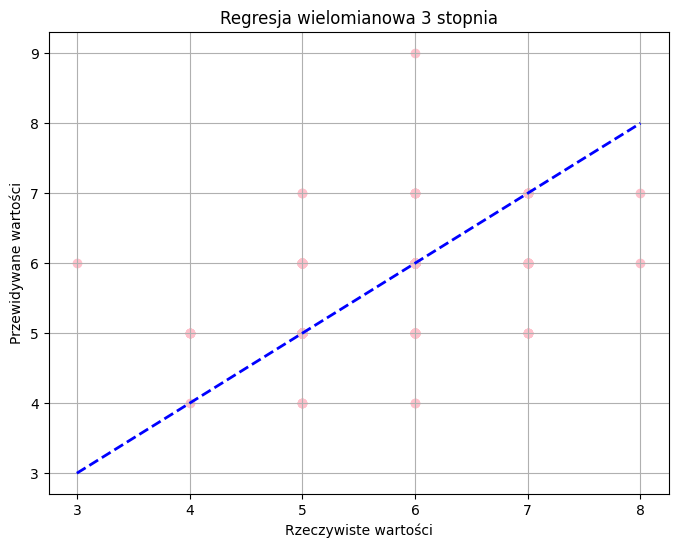

In [94]:
plt.figure(figsize=(8, 6))
plt.scatter(Y_test, y_predic_poly3, color='pink')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], color='blue', linestyle='--', linewidth=2)
plt.xlabel('Rzeczywiste wartości')
plt.ylabel('Przewidywane wartości')
plt.title('Regresja wielomianowa 3 stopnia')
plt.grid(True)
plt.show()

#**Cross Validation wielomianowa 3 stopnia**

In [130]:
rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
lin = LinearRegression()
xpol3 = PolynomialFeatures(3)
X3 = xpol3.fit_transform(X_df)
cv_scores_poly3 = cross_val_score(lin, X3, Y_df, cv=rkf,scoring='r2')
print(cv_scores_poly3)

[-0.11843361  0.17835855 -0.19742193  0.16902862  0.1968784   0.20903613
 -0.07644387  0.23773166  0.15208415  0.22311701  0.3698757   0.06887355
  0.29241905  0.06247158  0.1175968 ]


#**Cross Validation KNN**

In [129]:
knn_cv = KNeighborsRegressor(n_neighbors=3)
cv_scores_knn = cross_val_score(knn_cv, X_df, Y_df, cv=rkf,scoring='r2')
print(cv_scores_knn)

[0.1836834  0.27621055 0.23097297 0.34297279 0.35365711 0.31606408
 0.14316853 0.29228431 0.36727239 0.24387162 0.4185807  0.25707085
 0.24272345 0.13944581 0.19567606]


In [128]:
sklearn.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',

#**Box plot porówniania cross validation wszystkich modeli**

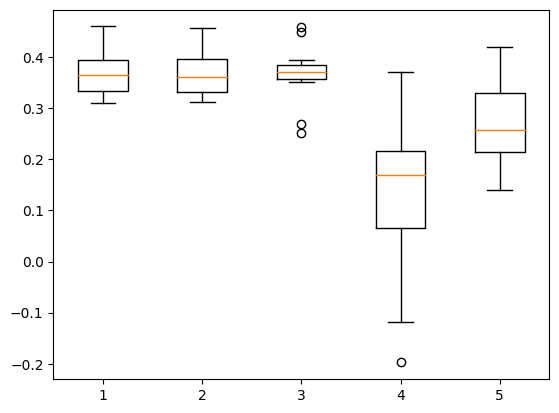

In [140]:
plt.boxplot([cv_scores_lin,cv_scores_hub, cv_scores_poly2, cv_scores_poly3, cv_scores_knn])
plt.show()